# Ensemble YOLOv8 and U-Net Model

In [1]:
import numpy as np
import pandas as pd
import yaml
import os
import gc
import cv2
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader, Dataset
from ultralytics import YOLO
from ultralytics.data.converter import convert_coco

from skimage import segmentation, filters, morphology, color, measure, io
from skimage.segmentation import slic, mark_boundaries

METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0  , 0  , 0  ),
        (230, 25 , 75 ),
        (60 , 180, 75 ),
        (255, 225, 25 ),
        (0  , 130, 200),
        (145, 30 , 180),
        (70 , 240, 240),
        (240, 50 , 230),
        (210, 245, 60 ),
        (250, 190, 190),
        (0  , 128, 128),
        (170, 110, 40 ),
        (255, 250, 200),
        (128, 0  , 0  ),
        (170, 255, 195),
        (128, 128, 0  ),
        (255, 215, 180),
        (0  , 0  , 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Parameters
NUM_CLASSES = 19
IMG_SIZE    = 640
OG_HEIGHT   = 1512
OG_WIDTH    = 2016
label_ids   = {e: i for i, e in enumerate(METAINFO['classes'])}

# 1. Data

In [2]:
PATH = 'dataset/'
BIN_PATH = 'bin/'
YOLO_PREDICT = 'yolov8/predictions/'
MODEL_PATH = 'yolov8/models/weights/'
if not os.path.exists(YOLO_PREDICT):
    os.makedirs(YOLO_PREDICT)

def get_dfs():
    train_df = pd.read_csv(PATH + 'train.csv')
    val_df   = pd.read_csv(PATH + 'val.csv'  )
    test_df  = pd.read_csv(PATH + 'test.csv' )
    return (train_df, val_df, test_df)

train_df, val_df, test_df = get_dfs()

# 2. Generating YOLO structured datasets

### YOLO formatted labels

In [3]:
def create_yolo_labels(images_dest, labels_dest, df, n_class, create_path=False):
    if not os.path.exists(labels_dest):
        os.makedirs(labels_dest)
    if not os.path.exists(images_dest):
        os.makedirs(images_dest)

    for image_path, label_path in zip(df['im_path'], df['label_path']):
        image = os.path.basename(image_path)

        # Construct the full path to the destination label_txt
        if create_path:
            image_dest = os.path.join(images_dest, image)
            if not os.path.exists(image_dest):
                shutil.copy(image_path, image_dest)

        # create yolo labels
        label_dest = image.replace('.png', '.txt')
        convert_label_to_yolo(
            label_path, f'{labels_dest}\\{label_dest}', n_class
        )


def convert_label_to_yolo(label_path, out_path, n_class):
    label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    height, width = label_img.shape

    with open(out_path, 'w') as label_txt:
        for class_id in range(n_class):
            # Create a binary mask for the current class
            class_mask = cv2.inRange(label_img, class_id, class_id)

            # Find contours for the current class
            contours, _ = cv2.findContours(
                class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )

            for cnt in contours:
                if len(cnt) < 3:
                    continue
                normalized_points = [
                    (point[0][0] / width, point[0][1] / height) for point in cnt
                ]
                label_txt.write(
                    f'{class_id} ' + " ".join(
                        f'{x:.6f} {y:.6f}' for x, y in normalized_points
                    ) + "\n"
                )

### Generate structured dataset

In [ ]:
datasets = ['train' , 'val' ]
dfs      = [train_df, val_df]
for i, ds in enumerate(datasets):
    images_destination = PATH + f'{ds}/images'
    labels_destination = PATH + f'{ds}/labels'
    create_yolo_labels(
        images_destination, labels_destination, dfs[i], NUM_CLASSES,
        # create_path=True
    )

# 3. YOLOv8 Training

In [3]:
cuda_avail = torch.cuda.is_available()
if cuda_avail:
    torch.cuda.set_device(0)
    print("GPU available")
else:
    print("No GPU found")
print(f'Device count  : {torch.cuda.device_count()}')
print(f'Device in-use : {torch.cuda.current_device()}')

# model = YOLO('yolov8s-seg.yaml')
# model.model.nc    = NUM_CLASSES
# model.model.names = METAINFO['classes']

model = YOLO(MODEL_PATH + 'best.pt')

GPU available
Device count  : 1
Device in-use : 0


In [ ]:
# Train the model
model.train(
    data='dataset.yaml',
    epochs=30,
    batch=16,
    optimizer='AdamW',
    device=0,
    imgsz=640,
    patience=10,
    rect=False,
    label_smoothing=0.0,
    verbose=False,
    # pretrained=True,
)

# 4. Postprocessing helpers

Requires some additional smoothing and small object removal.

In [235]:
def label_to_rgb(label, palette=METAINFO['palette']):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image


def refine_segmentation(image, mask):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Smooth the mask using morphological operations
    refined_mask = morphology.opening(mask, morphology.disk(3))
    refined_mask = morphology.closing(refined_mask, morphology.disk(3))
    refined_mask = measure.label(refined_mask)
    return refined_mask


def reassign_unlabeled(prediction, unlabeled_class=0):
    prediction = prediction.astype('int64')
    unlabeled_indices = np.where(prediction == unlabeled_class)
    for y, x in zip(*unlabeled_indices):
        # Get the 8-connected neighbors, remove unlabeled from neighbors
        neighbors = prediction[max(0, y-1):y+2, max(0, x-1):x+2].flatten()
        neighbors = neighbors[neighbors != unlabeled_class]
        if len(neighbors) == 0:
            continue
        # Assign the most frequent class among the neighbors to the unlabeled pixel
        prediction[y, x] = np.bincount(neighbors).argmax()
    return prediction


def convert_instance_to_semantic(results, num_classes):
    _, height, width = results[0].masks.data.cpu().numpy().shape  # Get the size of the input image
    semantic_map = np.zeros((height, width), dtype=np.uint8)
    
    # Iterate through each detected instance
    for result in results:
        masks = result.masks.data.cpu().numpy()
        boxes = result.boxes
        labels = boxes.cls.cpu().numpy()

        for label, mask, box in zip(labels, masks, boxes.xyxy):
            [ymin, xmin, ymax, xmax] = box
            ymin = int(max(0, ymin))
            xmin = int(max(0, xmin))
            ymax = int(min(height, ymax))
            xmax = int(min(width, xmax))
            semantic_map[mask != 0] = label
            semantic_map[ymin:ymax, xmin:xmax] = label # remove?

    segment_color = label_to_rgb(semantic_map)
    return segment_color

# 5. Predictions and Plotting

In [236]:
def get_yolo_predictions(model, test_df, indices=None, rgb=True):
    if indices is None:
        indices = range(len(test_df))
    indices = np.array(indices)
    X_pred = np.array(test_df['im_path'])
    X_pred = list(X_pred[indices])

    results = model(
        X_pred, device=0, max_det=100, conf=0.2, retina_masks=True
    )
    _, height, width = results[0].masks.data.cpu().numpy().shape
    semantic_maps = [None] * len(X_pred)

    for i, result in enumerate(results):
        masks  = result.masks.data.cpu().numpy()
        boxes  = result.boxes
        labels = boxes.cls.cpu().numpy()
        semantic_map = np.zeros((height, width), dtype=np.uint8)
    
        for label, mask in zip(labels, masks):
            semantic_map[mask != 0] = label
        if rgb:
            semantic_map = label_to_rgb(semantic_map)
        semantic_maps[i] = semantic_map
    return semantic_maps


def plot_predictions(
    model, test_df, indices, title, font_factor=1, save=True
):
    # row, column, and factoring
    cols = 3
    rows = len(indices)
    y_axis_factor = 1*(rows-1)
    x_axis_factor = 1

    # figure and axis
    fig, ax = plt.subplots(
        rows, cols, figsize=(40*x_axis_factor, 15*y_axis_factor)
    )
    fig.suptitle(title, fontsize=45*font_factor)
    subtitles = ["Original Image", "Ground Truth", "Prediction"]
    images = np.array(test_df['im_path']).astype(str)
    ground_truths = np.array(test_df['label_path']).astype(str)
    predictions = get_yolo_predictions(model, test_df, indices)
    imread_rgb = lambda img: cv2.cvtColor(cv2.imread(img, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)

    # for each prediction
    for i in range(rows):
        disp_images = [
            imread_rgb(images[i]),
            imread_rgb(ground_truths[i].replace('indexLabel', 'label')),
            predictions[i]
        ]
        for j in range(cols):
            ax[i,j].imshow(disp_images[j])
            ax[i,j].set_title(subtitles[j], fontsize=30*font_factor)
            ax[i,j].axis('off')

    if save:
        fig.savefig(BIN_PATH + title)

## 5.1. YOLO


0: 480x640 1 dirt, 14 tree-trunks, 1 tree-foliage, 9 skys, 3 grasss, 62.5ms
1: 480x640 1 dirt, 14 tree-trunks, 1 tree-foliage, 1 log, 12 skys, 2 grasss, 62.5ms
2: 480x640 1 dirt, 9 tree-trunks, 4 tree-foliages, 12 skys, 2 grasss, 62.5ms
Speed: 2.3ms preprocess, 62.5ms inference, 61.3ms postprocess per image at shape (1, 3, 480, 640)


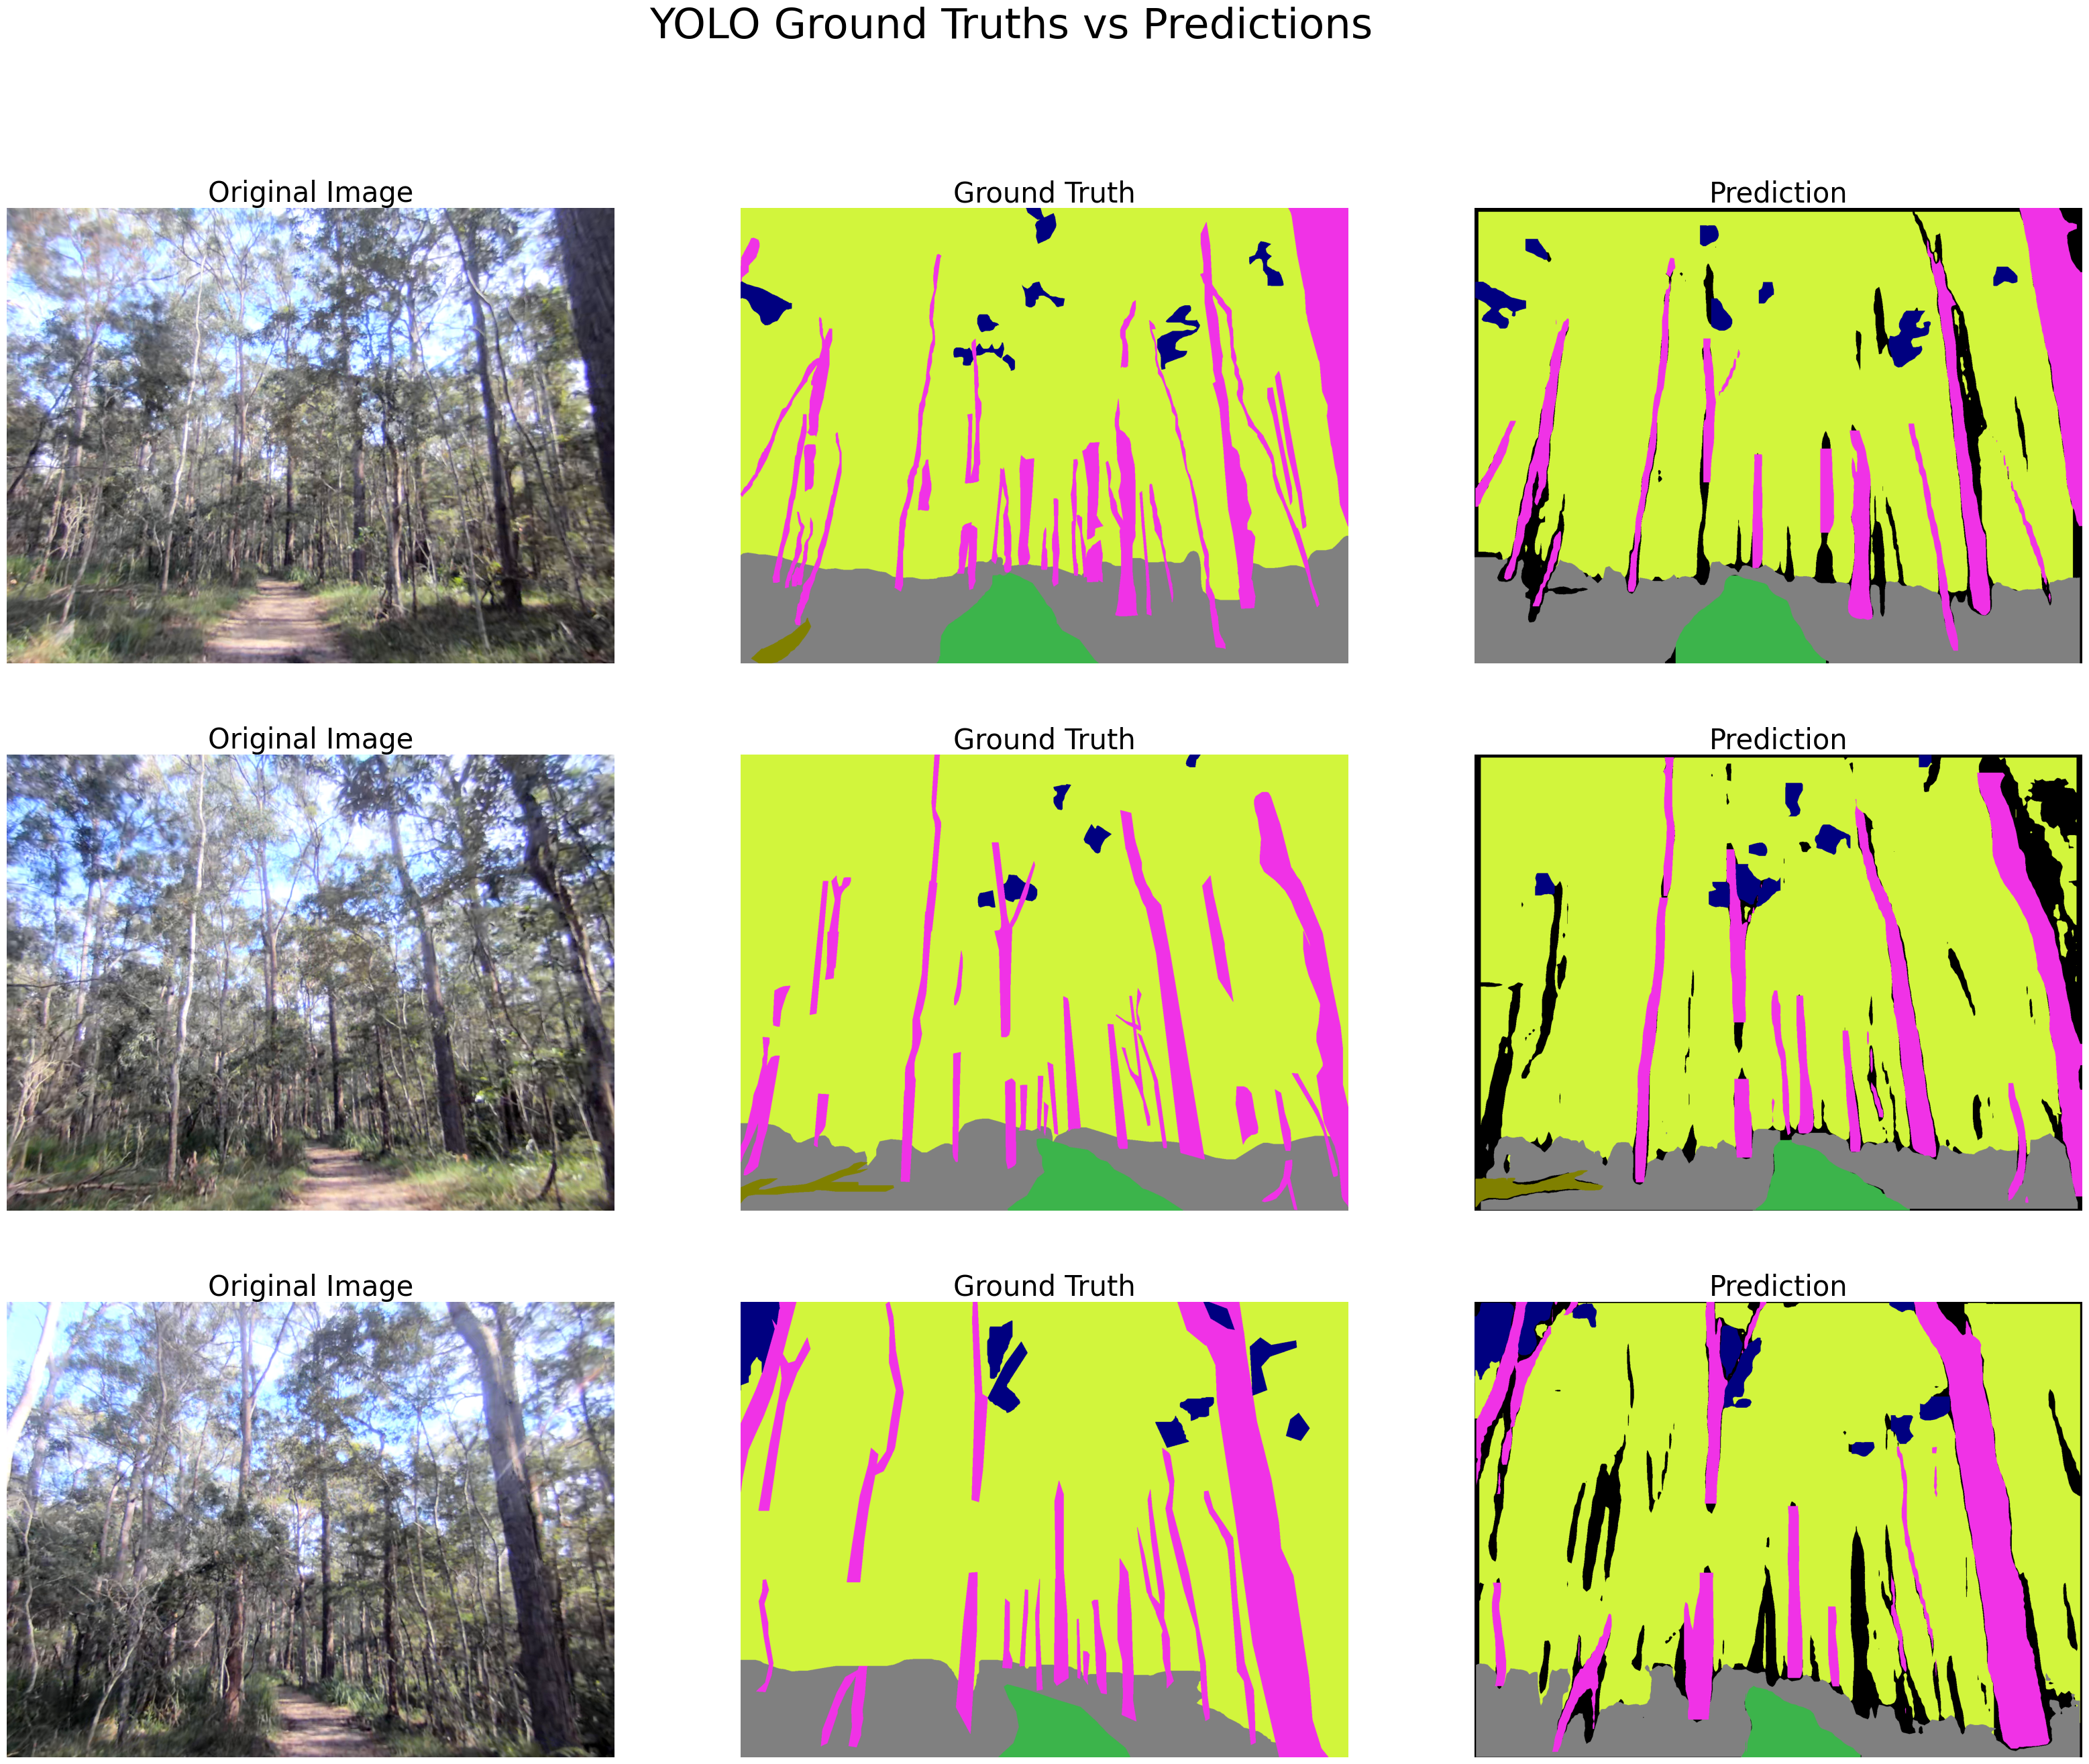

In [9]:
plot_predictions(
    model, test_df, range(3), "YOLO Ground Truths vs Predictions"
)

Possible things to do:
* Change the border unlabeled to the majority.
* Region supression - rather, if the region is small enough, use majority rule to transform it to the appropriate color

## 5.2. Ensemble YOLO + U-Net

#### **Helpers**

In [42]:
def get_img_and_labels(df):
    images = np.array(df['im_path']).astype(str)
    labels = np.array(df['label_path']).astype(str)
    return images, labels

def resize_image(path, shape=(IMG_SIZE, int(IMG_SIZE/OG_WIDTH*OG_HEIGHT))):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = cv2.resize(img, shape)
    return img

def get_corresponding_prediction(path):
    prediction_path = YOLO_PREDICT + path.split('/')[-1]
    prediction = cv2.imread(prediction_path, cv2.IMREAD_UNCHANGED)
    return prediction

#### **Model**

In [6]:
class EnsembleYOLO:
    __slots__ = [
        "_yolo",
        "_other",
        "_weight",
        "transform",
    ]

    def __init__(self, yolo, other, weight: float = 1):
        assert not yolo is None
        self._yolo = yolo
        self._other = other
        self._weight = weight
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def _set_weight(self, weight: float):
        self._weight = weight

    def _labels_iou(self, test_labels, img_size, num_classes, resize):
        ious = [np.nan] * num_classes
        for label in range(num_classes):
            total_intersection = np.uint64(0)
            total_union = np.uint64(0)
            for test_label in test_labels:
                ground_truth = read_img(test_label, resize=resize)
                prediction = get_corresponding_prediction(test_label)

                # Create binary masks for the given label
                gt_mask = (ground_truth == label)
                pred_mask = (prediction == label)
    
                # Calculate intersection and union
                intersection = np.sum(gt_mask & pred_mask)
                union = np.sum(gt_mask | pred_mask)
                total_intersection += intersection
                total_union += union
    
            iou = total_intersection / total_union if total_union > 0 else np.nan
            ious[label] = iou
        return ious

    def _display_iou_score(self, ious):
        classes = palette = METAINFO['classes']
        merged_classes = []
        merged_ious = []

        for idx, class_name in enumerate(classes):
            if class_name == "pole":
                # Merge pole IoU into other-object
                other_object_idx = classes.index("other-object")
                ious[other_object_idx] += ious[idx]
            elif class_name == "asphalt":
                # Merge asphalt IoU into other-terrain
                other_terrain_idx = classes.index("other-terrain")
                ious[other_terrain_idx] += ious[idx]
            elif class_name not in ["vehicle", "pole", "asphalt", "unlabelled"]:
                merged_classes.append(class_name)
                merged_ious.append(ious[idx])

        class_iou_pairs = list(zip(merged_classes, merged_ious))
        sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])
        print("\nIoU score\n============")
        for class_name, iou in sorted_class_iou_pairs:
            print(f"{class_name}: {iou * 100: .2f}")
        miou = np.nanmean(merged_ious)
        print(f"Mean IoU: {miou * 100: .2f}")

    def display_iou_score(self, test_labels, resize=False):
        ious = self._labels_iou(test_labels, IMG_SIZE, NUM_CLASSES, resize=resize)
        self._display_iou_score(ious)

    def _other_predict(self, img):
        ts = read_tensor_img(img).cuda()
        with torch.no_grad():
            results = self._other(ts)
        preds = torch.argmax(results[0], dim=1)
        return preds

    def _interpret_prediction(self, results, img_shape, torch=False):
        result = results[0]
        if not torch:
            prediction = np.zeros(img_shape, dtype=np.uint8)
            masks  = result.masks.data.cpu().numpy()
            labels = result.boxes.cls.cpu().numpy()
            for label, mask in zip(labels, masks):
                prediction[mask != 0] = label
            del masks
            del labels
            gc.collect()
        else:
            prediction = result.cpu().detach().numpy()
        del results
        gc.collect()
        return prediction

    def predict(self, inputs) -> np.ndarray:
        # get unet prediction and apply immediately here --> save memory
        X_pred = list(inputs)
        img_shape = (OG_HEIGHT, OG_WIDTH) if self._other is None else (IMG_SIZE, IMG_SIZE)

        for path in X_pred:
            img = path if self._other is None else read_img(path)

            # prediction
            yolo_result = self._yolo(
                img, verbose=False, device=0, max_det=100, conf=0.2, retina_masks=True
            )
            prediction = self._interpret_prediction(yolo_result, img_shape)

            # apply unlabeled mask to other model
            if not self._other is None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                unet_results = self._other_predict(img)
                unet_result = unet_results[0]
                unet_result = self._interpret_prediction(unet_results, img_shape, torch=True)
                
                unlabeled_mask = prediction == 0
                prediction[unlabeled_mask] = unet_result[unlabeled_mask]

                del unet_result
                del unet_results
                del unlabeled_mask
            cv2.imwrite(YOLO_PREDICT + path.split('/')[-1], prediction)

            # manually free memory
            del yolo_result
            del prediction
            gc.collect()

### **Results**

#### **YOLO only**

In [96]:
yolo_model = EnsembleYOLO(model, None)
test_inputs, test_labels = get_img_and_labels(test_df)

In [164]:
# predictions
yolo_model.predict(test_inputs[:2])

In [83]:
yolo_model.display_iou_score(test_labels)


IoU score
asphalt/concrete:  0.00
bush/shrub:  11.94
dirt:  67.67
fence:  0.00
grass:  54.29
gravel:  0.00
log:  9.38
mud:  0.00
other-object:  5.65
other-structure:  31.60
other-terrain:  0.00
rock:  0.00
sky:  77.03
tree-foliage:  81.65
tree-trunk:  44.99
water:  14.23
Mean IoU:  24.90


In [155]:
yolo_model.display_iou_score(test_labels[:1])


IoU score
asphalt/concrete:  nan
bush/shrub:  nan
dirt:  92.61
fence:  nan
grass:  80.56
gravel:  nan
log:  0.00
mud:  nan
other-object:  nan
other-structure:  nan
other-terrain:  nan
rock:  nan
sky:  40.64
tree-foliage:  84.81
tree-trunk:  55.78
water:  nan
Mean IoU:  59.07


#### **U-Net Ensembled**

In [99]:
def read_img(path, resize=True):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if resize:
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img

def get_transform():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

def read_tensor_img(img):
    tensor = get_transform()(img)
    return tensor.unsqueeze(0)

In [59]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class ImprovedUNet(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedUNet, self).__init__()
        
        def conv_block(in_channels, out_channels, dilation=1):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        def upconv_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
        self.enc1 = conv_block(3, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.bottleneck = conv_block(512, 1024, dilation=2)
        
        self.upconv4 = upconv_block(1024, 512)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.dec4 = conv_block(1024, 512)
        
        self.upconv3 = upconv_block(512, 256)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.dec3 = conv_block(512, 256)
        
        self.upconv2 = upconv_block(256, 128)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.dec2 = conv_block(256, 128)
        
        self.upconv1 = upconv_block(128, 64)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.dec1 = conv_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, num_classes, kernel_size=1)
        
        # Deep supervision
        self.deep_sup4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.deep_sup3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.deep_sup2 = nn.Conv2d(128, num_classes, kernel_size=1)
        
    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        bottleneck = self.bottleneck(self.pool(enc4))
        
        dec4 = self.upconv4(bottleneck)
        dec4 = self.att4(g=dec4, x=enc4)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        
        dec3 = self.upconv3(dec4)
        dec3 = self.att3(g=dec3, x=enc3)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        
        dec2 = self.upconv2(dec3)
        dec2 = self.att2(g=dec2, x=enc2)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        
        dec1 = self.upconv1(dec2)
        dec1 = self.att1(g=dec1, x=enc1)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))
        
        out = self.conv_last(dec1)
        
        # Deep supervision outputs
        deep_sup4 = F.interpolate(self.deep_sup4(dec4), scale_factor=8, mode='bilinear', align_corners=True)
        deep_sup3 = F.interpolate(self.deep_sup3(dec3), scale_factor=4, mode='bilinear', align_corners=True)
        deep_sup2 = F.interpolate(self.deep_sup2(dec2), scale_factor=2, mode='bilinear', align_corners=True)
        
        if self.training:
            return out, deep_sup4, deep_sup3, deep_sup2
        else:
            return out

In [168]:
class EnsembleYOLO:
    __slots__ = [
        "_yolo",
        "_other",
        "_weight",
        "transform",
    ]

    def __init__(self, yolo, other, weight: float = 1):
        assert not yolo is None
        self._yolo = yolo
        self._other = other
        self._weight = weight
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def _set_weight(self, weight: float):
        self._weight = weight

    def _labels_iou(self, test_labels, num_classes, resize):
        ious = [np.nan] * num_classes
        for label in range(num_classes):
            total_intersection = np.uint64(0)
            total_union = np.uint64(0)
            for test_label in test_labels:
                ground_truth = read_img(test_label, resize=resize)
                prediction = get_corresponding_prediction(test_label)

                # Create binary masks for the given label
                gt_mask = (ground_truth == label)
                pred_mask = (prediction == label)
    
                # Calculate intersection and union
                intersection = np.sum(gt_mask & pred_mask)
                union = np.sum(gt_mask | pred_mask)
                total_intersection += intersection
                total_union += union
    
            iou = total_intersection / total_union if total_union > 0 else np.nan
            ious[label] = iou
        return ious

    def _display_iou_score(self, ious):
        classes = palette = METAINFO['classes']
        merged_classes = []
        merged_ious = []

        for idx, class_name in enumerate(classes):
            if class_name == "pole":
                # Merge pole IoU into other-object
                other_object_idx = classes.index("other-object")
                ious[other_object_idx] += ious[idx]
            elif class_name == "asphalt":
                # Merge asphalt IoU into other-terrain
                other_terrain_idx = classes.index("other-terrain")
                ious[other_terrain_idx] += ious[idx]
            elif class_name not in ["vehicle", "pole", "asphalt", "unlabelled"]:
                merged_classes.append(class_name)
                merged_ious.append(ious[idx])

        class_iou_pairs = list(zip(merged_classes, merged_ious))
        sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])
        print("\nIoU score\n============")
        for class_name, iou in sorted_class_iou_pairs:
            print(f"{class_name}: {iou * 100: .2f}")
        miou = np.nanmean(merged_ious)
        print(f"Mean IoU: {miou * 100: .2f}")

    def display_iou_score(self, test_labels, resize=False):
        ious = self._labels_iou(test_labels, IMG_SIZE, NUM_CLASSES, resize=resize)
        self._display_iou_score(ious)

    def _other_predict(self, img):
        ts = read_tensor_img(img).cuda()
        with torch.no_grad():
            results = self._other(ts)
        preds = torch.argmax(results[0], dim=1)
        return preds

    def _interpret_prediction(self, results, img_shape, torch=False):
        result = results[0]
        if not torch:
            prediction = np.zeros(img_shape, dtype=np.uint8)
            masks  = result.masks.data.cpu().numpy()
            labels = result.boxes.cls.cpu().numpy()
            for label, mask in zip(labels, masks):
                prediction[mask != 0] = label
            del masks
            del labels
            gc.collect()
        else:
            prediction = result.cpu().detach().numpy()
        del results
        gc.collect()
        return prediction

    def predict(self, inputs) -> np.ndarray:
        # get unet prediction and apply immediately here --> save memory
        X_pred = list(inputs)
        img_shape = (OG_HEIGHT, OG_WIDTH) if self._other is None else (IMG_SIZE, IMG_SIZE)

        for path in X_pred:
            img = path if self._other is None else read_img(path)

            # prediction
            yolo_result = self._yolo(
                img, verbose=False, device=0, max_det=100, conf=0.2, retina_masks=True
            )
            prediction = self._interpret_prediction(yolo_result, img_shape)

            # apply unlabeled mask to other model
            if not self._other is None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                unet_results = self._other_predict(img)
                unet_result = unet_results[0]
                unet_result = self._interpret_prediction(unet_results, img_shape, torch=True)
                
                unlabeled_mask = prediction == 0
                prediction[unlabeled_mask] = unet_result[unlabeled_mask]

                del unet_result
                del unet_results
                del unlabeled_mask
            cv2.imwrite(YOLO_PREDICT + path.split('/')[-1], prediction)

            # manually free memory
            del yolo_result
            del prediction
            gc.collect()

In [166]:
# Initialize model, loss, optimizer, and scheduler
unet_model = ImprovedUNet(NUM_CLASSES).cuda()
unet_model.load_state_dict(torch.load(MODEL_PATH + 'adamw_model_unet.pth'))
ensemble_model = EnsembleYOLO(model, unet_model)

In [167]:
# predictions
ensemble_model.predict(test_inputs)

In [169]:
ensemble_model.display_iou_score(test_labels, resize=True)

0.0
15893.0
98971038.0
1031756.0
1641697.0
1671059.0
493982.0
140032092.0
542760799.0
16948310.0
1446924.0
4969557.0
299705.0
311300.0
542614.0
6497050.0
1784217.0
57007331.0
148561926.0

IoU score
asphalt/concrete:  0.00
bush/shrub:  8.17
dirt:  65.94
fence:  0.00
grass:  57.71
gravel:  0.60
log:  6.36
mud:  0.00
other-object:  8.05
other-structure:  30.21
other-terrain:  0.00
rock:  0.00
sky:  76.51
tree-foliage:  83.07
tree-trunk:  52.38
water:  3.71
Mean IoU:  24.54


In [210]:
def remove_border_objects(thresh):
    """
    Remove any region that has area size less than a specified fraction of the largest
    """
    # Find contours of objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask for objects touching the border
    mask = np.zeros_like(thresh)
    height, width = thresh.shape[:2]

    # Check if contour touches the border
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if x == 0 or y == 0 or x + w == width or y + h == height:
            cv2.drawContours(mask, [contour], -1, 255, -1)
    mask = 255 - mask # complement
    
    # Apply the mask to remove border-touching objects
    ret = cv2.bitwise_and(thresh, thresh, mask=mask)
    return ret


def supress_region_size(img, small_region_frac):
    """
    Remove any region that has area size less than a specified fraction of the largest
    """
    # find the largest area
    ret = np.copy(img)
    contours, _ = cv2.findContours(ret, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        max_area = max(cv2.contourArea(x) for x in contours)
    
        # fill any region with area less than the specified fraction of the max
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < small_region_frac * max_area:
                cv2.drawContours(ret, [contour], -1, (0,0,0), -1)
    return ret


from skimage import measure, morphology, segmentation

from scipy.ndimage import label
from collections import Counter

def find_and_fill_small_regions(image, size_threshold_ratio=0.1):
    # Step 1: Label the connected components in the image
    # labeled_image, num_features = label(image)
    labeled_image, num_features = measure.label(image, background=0, return_num=True)
    
    # Calculate the area of each region
    region_areas = np.bincount(labeled_image.ravel())
    
    # Determine the maximum region size
    max_region_size = np.max(region_areas)
    
    # Calculate the size threshold
    size_threshold = max_region_size * size_threshold_ratio
    
    # Create a copy of the image to modify
    modified_image = image.copy()
    
    # Step 2: Identify and process small regions
    for region_label, region_size in enumerate(region_areas):
        if region_label == 0:  # Skip the background
            continue
        if region_size < size_threshold:
            # Find the coordinates of the small region
            region_coords = np.column_stack(np.where(labeled_image == region_label))
            
            # Step 3: Determine the neighboring labels
            neighboring_labels = []
            # print(region_coords[2])
            for [y, x, _] in region_coords:
                # Check the 8-connected neighbors
                neighbors = labeled_image[max(0, y-1):y+2, max(0, x-1):x+2].flatten()
                neighbors = neighbors[neighbors != region_label]  # Exclude the current region
                neighboring_labels.extend(neighbors)
            
            # Exclude the background label (0)
            neighboring_labels = [label for label in neighboring_labels if label != 0]
            
            # Find the most common neighboring label
            if neighboring_labels:
                most_common_label = Counter(neighboring_labels).most_common(1)[0][0]
                
                # Step 4: Fill the small region with the most common neighboring label
                for [y, x, _] in region_coords:
                    modified_image[y, x] = most_common_label
    
    return modified_image

In [232]:
def reassign_unlabeled(prediction, unlabeled_class=0):
    prediction = prediction.astype('int64')
    unlabeled_indices = np.where(prediction == unlabeled_class)
    for y, x in zip(*unlabeled_indices):
        # Get the 8-connected neighbors, remove unlabeled from neighbors
        neighbors = prediction[max(0, y-1):y+2, max(0, x-1):x+2].flatten()
        neighbors = neighbors[neighbors != unlabeled_class]
        if len(neighbors) == 0:
            continue
        # Assign the most frequent class among the neighbors to the unlabeled pixel
        prediction[y, x] = np.bincount(neighbors).argmax()
    return prediction

def labels_iou(predictions, ground_truths, num_classes=19):
    ious = [np.nan] * num_classes
    for label in range(num_classes):
        total_intersection = np.uint64(0)
        total_union = np.uint64(0)
        for prediction, ground_truth in zip(predictions, ground_truths):
            # Create binary masks for the given label
            gt_mask = (ground_truth == label)
            pred_mask = (prediction == label)

            # Calculate intersection and union
            intersection = np.sum(gt_mask & pred_mask)
            union = np.sum(gt_mask | pred_mask)
            total_intersection += intersection
            total_union += union

        iou = total_intersection / total_union if total_union > 0 else np.nan
        ious[label] = iou
    return ious

def display_iou_score(ious):
    classes = palette = METAINFO['classes']
    merged_classes = []
    merged_ious = []

    for idx, class_name in enumerate(classes):
        if class_name == "pole":
            # Merge pole IoU into other-object
            other_object_idx = classes.index("other-object")
            ious[other_object_idx] += ious[idx]
        elif class_name == "asphalt":
            # Merge asphalt IoU into other-terrain
            other_terrain_idx = classes.index("other-terrain")
            ious[other_terrain_idx] += ious[idx]
        elif class_name not in ["vehicle", "pole", "asphalt", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(ious[idx])

    class_iou_pairs = list(zip(merged_classes, merged_ious))
    sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])
    print("\nIoU score\n============")
    for class_name, iou in sorted_class_iou_pairs:
        print(f"{class_name}: {iou * 100: .2f}")
    miou = np.nanmean(merged_ious)
    print(f"Mean IoU: {miou * 100: .2f}")

In [248]:
iteration = 0

n = 500
st = iteration * n
en = (iteration+1) * n
sth_reses = []
sth_labels = []

for i in range(st, en):
    sth_labels.append(get_corresponding_prediction(test_labels[i]))
    sth_reses.append(reassign_unlabeled(sth_label))

In [249]:
display_iou_score(labels_iou(sth_reses, sth_labels))


IoU score
asphalt/concrete:  nan
bush/shrub:  0.00
dirt:  12.94
fence:  nan
grass:  26.80
gravel:  0.00
log:  0.00
mud:  nan
other-object:  nan
other-structure:  0.00
other-terrain:  nan
rock:  nan
sky:  5.17
tree-foliage:  59.12
tree-trunk:  6.71
water:  0.00
Mean IoU:  11.07
